# Support Vector Machine

- 先来个简单版本的SMO

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
def select_random(index, m):
    j = index
    while j == index:
        j = int(np.random.uniform(0, m))
    return j

In [11]:
def clipAlpha(alpha, High, Low):
    if alpha > High:
        alpha = High
    elif Low > alpha:
        alpha = Low
    return alpha

In [12]:
select_random(2, 10)

7

In [13]:
df = pd.read_csv('testSet.txt', delimiter='\t', names=['x1', 'x2', 'y'])

In [14]:
df.head()

,x1,x2,y
0,3.542485,1.977398,-1
1,3.018896,2.556416,-1
2,7.551510,-1.580030,1
3,2.114999,-0.004466,-1
4,8.127113,1.274372,1


In [15]:
def simpleSMO(df, C, toler, maxIter):
    data = df.loc[:, ['x1', 'x2']]
    labels = df.loc[:, 'y'].values
    b = 0
    m,n = df.shape
    alphas = np.zeros((m, ))
    iteration = 0
    while iteration < maxIter:
        alphaPairsChanged = 0
        for i in range(m):
            gXi = np.dot(alphas*labels, np.dot(data, data.loc[i].T))+ b# prediction of class
            Ei = gXi - float(labels[i]) # the error between predcition and  real class
            if ((labels[i]*Ei < -toler) and (alphas[i] < C)) or \
            ((labels[i]*Ei > toler) and (alphas[i] > 0)): # test the error abs(Ei) # about KKT condition???????
                j = select_random(i, m) # select an alpha_j randomly
                gXj = np.dot(alphas*labels, np.dot(data, data.loc[j].T)) + b
                Ej = gXj - float(df.loc[j, 'y'])
                alphaIold = alphas[i].copy() # save the old alpha_i
                alphaJold = alphas[j].copy()
                if labels[i] != labels[j]:
                    Low = max(0, alphas[j] - alphas[i])
                    High = min(C, C + alphas[j] - alphas[i])
                else:
                    Low = max(0, alphas[j] + alphas[i] - C)
                    High = min(C, alphas[j] + alphas[i])
                if Low == High:
                    # print "L==H"
                    continue
                eta = 2.0 * data.loc[i].dot(data.loc[j].T) - data.loc[i].dot(data.loc[i].T) - \
                      data.loc[j].dot(data.loc[j].T)    # the opmitmal amount to change alpha_j
                if eta >= 0:
                    # print "eta>=0"
                    continue
                alphas[j] -= labels[j]*(Ei - Ej)/eta
                alphas[j] = clipAlpha(alphas[j], High, Low)
                if (abs(alphas[j] - alphaJold) < 0.00001) :
                    # print "j not moving enough"
                    continue
                alphas[i] += labels[j]*labels[i]*(alphaJold - alphas[j]) # alpha_i is changed by the same amount
                                                                         # but oppsite direction
                
                b1 = b - Ei - labels[i]*(alphas[i] - alphaIold)*\
                     data.loc[i].dot(data.loc[i].T) - labels[j]*(alphas[j] - alphaJold)*\
                     data.loc[i].dot(data.loc[j].T)
                b2 = b - Ej - labels[i]*(alphas[i] - alphaIold)*\
                     data.loc[i].dot(data.loc[j].T) - labels[j]*(alphas[j] - alphaJold)*\
                     data.loc[j].dot(data.loc[j].T)
                
                if (0 < alphas[i]) and (C > alphas[i]):
                    b  = b1
                elif (0 < alphas[j]) and (C > alphas[j]):
                    b = b2
                else:
                    b = (b1 + b2)/2.0
                alphaPairsChanged += 1
                # print "iteration: %d, i: %d, pairs changed %d" % (iteration, i, alphaPairsChanged)
        if (alphaPairsChanged == 0):
            iteration += 1
        else:
            iteration = 0
        # print "Iteration number: %d" % iteration
    return b, alphas

In [16]:
b, alphas = simpleSMO(df, 0.6, 0.001, 40)

In [17]:
b

-3.7559531254064149

In [19]:
alphas[alphas>0]

array([ 0.07498325,  0.27659251,  0.05799535,  0.29358041])

## Get the support vectors

In [20]:
for i in range(100):
    if alphas[i] > 0.:
        print df.loc[i, :]

x1    4.658191
x2    3.507396
y    -1.000000
Name: 17, dtype: float64
x1    3.457096
x2   -0.082216
y    -1.000000
Name: 29, dtype: float64
x1    5.286862
x2   -2.358286
y     1.000000
Name: 54, dtype: float64
x1    6.080573
x2    0.418886
y     1.000000
Name: 55, dtype: float64


## Get the separating hyperplane

In [21]:
lables = df.loc[:, 'y'].values
data = df.loc[:, ['x1', 'x2']].values

In [22]:
w = np.dot(alphas*lables, data)

In [23]:
w

array([ 0.78625735, -0.25404849])

## Plot

In [24]:
x = np.linspace(-1, 10, 1000)

In [25]:
def f(x, w):
    return -w[0]*x/w[1]-b/w[1]

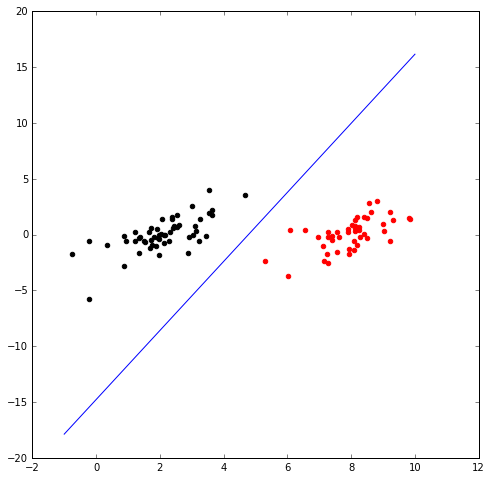

In [26]:
fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(df[df['y']==1].loc[: ,'x1'], df[df['y']==1].loc[: ,'x2'], color='r')
ax.scatter(df[df['y']==-1].loc[: ,'x1'], df[df['y']==-1].loc[: ,'x2'], color='k')
ax.plot(x, f(x, w))

# The Full Platt SMO

## Some support functions 

In [27]:
class optStruct:
    def __inti__(self, data, labels, C, toler):
        self.X = data
        self.labels = labels
        self.C = C
        self.tol = toler
        self.m = data.shape[0]
        self.alphas = np.zeros((self.m, ))
        self.b = 0
        self.errCache = np.zeros((self.m, 2))

In [28]:
def calculateEk(oS, k):
    fXk = np.dot(oS.alphas*oS.labels, np.dot(oS.data, oS.data.loc[k].T))+ oS.b
    Ek = fXk - float(oS.labels[k])
    return Ek

In [29]:
def selectJ(i, oS, Ei):
    maxK = -1
    maxDeltaE = 0
    Ej = 0
    oS.errCache[i] = [1, Ei]
    validEcacheList = nonzero(oS.errCache[:, 0].A)[0]
    if (len(validEcacheList)) > 1:
        for k in validEcacheList:
            if k == i:
                continue
            Ek = calculateEk(oS, k)
            deltaE = abs(Ei - Ek)
            if (deltaE > maxDeltaE):
                maxK = k
                maxDeltaE = deltaE
                Ej = Ek
        return maxK, Ej
    else:
        j = select_random(i, oS.m)
        Ej = calculateEk(oS, j)
    return j, Ej

In [31]:
def updateEk(oS, k):
    Ek = calculateEk(oS, k)
    oS.errCache[k] = [1, Ek]